In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt

import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


In [3]:
X = pickleLoad('X')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [3]:
XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [10]:
Means = pickleLoad('Means.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [4]:
def hardThreshold(x, s, T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    n = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0] = 0  # 去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1]  # 返回s-k个绝对最大值的索引.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(n)
    new[supp] = x[supp]

    return new

In [5]:
# IRLSPKS.
def IRLSPKS(y: np.ndarray, Phi: np.ndarray, T0=[],
            p: int = 1, tau=1e-1, mu=1e-6,
            maxIter: int = 100, eps=1e-6,
            returnIter=False,
            showIfMaxIter=False, showChangeRate=False):
    """
    `p`: Norm number, in (0,1]. \n
    `mu`: Normalizing param. \n
    `tau`: Short for tau^(2-p) in the paper. Weighting param. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    """
    n = Phi.shape[1]  # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    # Init.
    q = np.ones(n)  # q=(q1,...,qn)
    # Q = np.diag(q)
    # Inverse weight matrix. Not used so as to accelerate.
    x0 = (q * Phi).T.dot(np.linalg.inv(Phi @ (q * Phi).T) @ y)  # Weight by row.
    # Cost:O((m^2*n^2)^3)=poly(m,N).

    for t in range(maxIter):
        q = np.abs(x0)**(2-p)
        q[T0] *= tau**(-1)
        q += mu
        x1 = (q * Phi).T.dot(np.linalg.inv(Phi @ (q * Phi).T) @ y)
        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1

In [7]:
sampMats = pickleLoad('sampMats.pickle')
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
Supps = pickleLoad('Supps.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


In [8]:
# IRLSPKS simulate:
def IRLSPKS_simulate(X, sampMats, priorRatios, Supps):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = IRLSPKS(y, Phi, T0=T0, maxIter=10)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


XHat_pR_IRLSPKS = IRLSPKS_simulate(X[:,:1], sampMats, priorRatios, Supps)

One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:0
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:1
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:2
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:3
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:4
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:5
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:6
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:7
One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:0
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:0
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:1
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:2
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:3
One batch `XHat` recovered w.r.t. a measurement

In [11]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IRLSPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X[:,:1])**2)/20)
    errFig.append(err)


In [13]:
numMeasurements = np.arange(100,801,100)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]

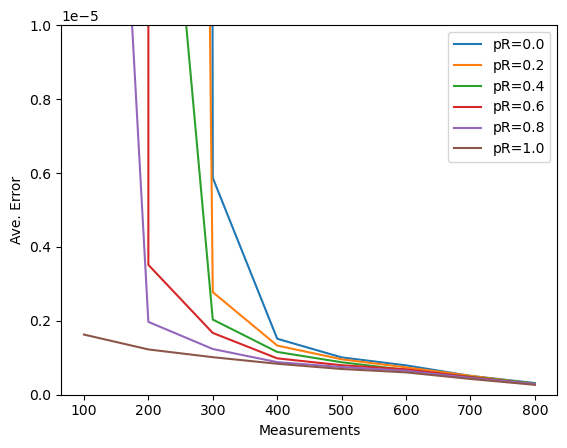

In [17]:
for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.ylim(0,1e-5)
plt.show()